In [399]:
import os
import glob
import time

from tqdm import tqdm
from dotenv import load_dotenv

from pymongo import MongoClient
import praw

import datetime as dt
import numpy as np
import pandas as pd

import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from sksurv.nonparametric import kaplan_meier_estimator as kme
from sksurv.preprocessing import OneHotEncoder as ohe
from sksurv.linear_model import CoxPHSurvivalAnalysis as cox

%config Completer.use_jedi = False

os.chdir('/shared/jackie/resilient-communities')

load_dotenv()

reddit = praw.Reddit(
    client_id=os.environ.get('REDDIT_CLIENT_ID_2'),
    client_secret=os.environ.get('REDDIT_CLIENT_SECRET_2'),
    user_agent=os.environ.get('REDDIT_USER_AGENT_2'),
    username=os.environ.get('REDDIT_USERNAME_2'),
    password=os.environ.get('REDDIT_PASSWORD_2')
)

client = MongoClient('localhost', 27017)
all_comments = client.resilient.all
popular_threads = client.resilient.popular_threads
pushshift_comments = client.pushshift_comments
pushshift_threads = client.pushshift_comments

# Get the total number of comments from PRAW stream.

We stream all comments into a single MongoDB collection.

In [287]:
pd.DataFrame.from_dict({
    'Comments': all_comments.estimated_document_count()
}, orient='index').rename(columns={0: 'N'}).style.format('{:,}')

,N
Comments,"525,300,000"


# Get r/popular threads stored in the collection.

Each r/popular thread and it's respective features are stored statically in a MongoDB collection. There are other collections (e.g., a collection for all Reddit comments and a collection for r/popular snapshots), but calculations should be ran on the r/popular collection. We derive features from those other collections in scripts. The scripts include: `store-popular-threads.py`, `generate-praw-features.py`, and `requery-comments.py`.

In [291]:
def get_popular_threads(filter={}, columns=[], n=None):
    
    # Adding index to the query projection.
    fields = {field: 1 for field in ['id'] + columns}
    
    cursor = popular_threads.find(filter, fields)
    
    if n is not None:
        cursor = cursor.limit(n)
    
    df = pd.DataFrame(cursor)
    
    if len(df) == 0:
        return df
    
    return df.set_index('id') \
        .drop(columns=['_id'])[columns]

get_popular_threads(
    columns=['author', 'title', 'subreddit', 'created_utc']
)

,author,title,subreddit,created_utc
id,,,,
tkwdrr,No-Gap240,Thanks a latte!,antiwork,1.648049e+09
tkl164,BrokenShutters,A truly awful aged like milk,agedlikemilk,1.648007e+09
tl0bmh,BolaSquirrel,PSA to invaders,Eldenring,1.648054e+09
tl4kfi,Ok_Inevitable_9461,...and they call the left snowflakes,PoliticalHumor,1.648059e+09
tkv6er,Father-TedCrilly,Worlds fattest man around the 1900’s.,AbsoluteUnits,1.648046e+09
...,...,...,...,...
v7vbxz,MrMoonchild_,Not everyone is a sport illustrator swimsuit m...,JoeRogan,1.654710e+09
v7vc22,beerbellybegone,Don't disrespect Grandma,quityourbullshit,1.654710e+09
v7vdbm,beerbellybegone,Preacher speaking God's word,MurderedByWords,1.654710e+09


# Get r/popular date range.

In [387]:
def get_popular_date_range():
    
    threads = get_popular_threads(columns=['created_utc', 'min_utc', 'max_utc'])
    
    print('Not local time, but UTC.')
    
    return pd.DataFrame.from_dict({
        'Earliest': {
            'Creation': dt.datetime.fromtimestamp(threads['created_utc'].min()),
            'Retrieval': dt.datetime.fromtimestamp(threads['min_utc'].min())
        },
        'Latest': {
            'Creation': dt.datetime.fromtimestamp(threads['created_utc'].max()),
            'Retrieval': dt.datetime.fromtimestamp(threads['max_utc'].max())
        }
    })

get_popular_date_range()

Not local time, but UTC.


,Earliest,Latest
Creation,2022-03-22 22:35:31,2022-06-08 13:58:40
Retrieval,2022-03-23 17:53:48,2022-06-08 16:13:54


# What's the feature coverage look like?

Answers: how many r/popular threads have comment, removed, and newcomer features?

In [663]:
def display_popular_thread_coverage():
    
    total_threads = popular_threads.estimated_document_count()
    comment_coverage = len(get_popular_threads(filter={'praw_utc': {'$ne': None}}))
    removed_coverage = len(get_popular_threads(filter={'requery_utc': {'$ne': None}}))
    newcomer_coverage = len(get_popular_threads(filter={'newcomer_utc': {'$ne': None}}))
    
    return pd.DataFrame.from_dict({
        'Total': {'N': total_threads, 'Percentage': total_threads / total_threads},
        'Comment': {'N': comment_coverage, 'Percentage': comment_coverage / total_threads},
        'Removed': {'N': removed_coverage, 'Percentage': removed_coverage / total_threads},
        'Newcomer': {'N': newcomer_coverage, 'Percentage': newcomer_coverage / total_threads}
    }, orient='index').style.format({'N': '{:,}', 'Percentage': '{:.2f}'})

display_popular_thread_coverage()

,N,Percentage
Total,"34,381",1.00
Comment,"33,883",0.99
Removed,"15,853",0.46
Newcomer,"6,057",0.18


# Describe distribution of features.

In [680]:
def describe_features(to_latex=False):
    
    threads = get_popular_threads(columns=[
        'created_to_popular',
        'popular_window',
        'active_window',
        'num_removed',
        'num_authors',
        'num_comments',
        'num_newcomers'
    ])
    
    table = pd.DataFrame()
    
    hour = int(dt.timedelta(hours=1).total_seconds())
    day = int(dt.timedelta(days=1).total_seconds())
    week = int(dt.timedelta(days=7).total_seconds())
    
    units = ['(hours)', '(hours)', '(days)', '', '', '', '']
    
    table = table.append((threads['created_to_popular'] / hour).describe())
    table = table.append((threads['popular_window'] / hour).describe())
    table = table.append((threads['active_window'] / day).describe())
    table = table.append((threads['num_comments']).describe())
    table = table.append((threads['num_authors']).describe())
    table = table.append((threads['num_removed'].describe()))
    table = table.append((threads['num_newcomers'].describe()))
    
    styles = {
        field: '{:.2f}' for field in ['25%', '50%', '75%', 'min', 'mean', 'max']
    }
    styles['count'] = '{:,.0f}'
    
    table.index = [indice.replace('_', ' ').replace('num', 'number of').title() + f' {unit}' 
                   for indice, unit in zip(table.index, units)]
    
    if to_latex:
        
        for column in table.columns:
            if column == 'count':
                table[column] = table[column].apply(lambda x: f'{x:,.0f}')
            else:
                table[column] = table[column].apply(lambda x: f'{x:.2f}')
        
        latex_table = table[['25%', '50%', '75%', 'min', 'mean', 'max', 'count']] \
            .to_latex(bold_rows=True, column_format='lrrrrrrr')
        
        for column in table.columns:
            if '%' in column:
                column = column.replace('%', '\%')

            latex_table = latex_table.replace(column, f'\\textbf{{{column.title()}}}')
        
        for rule in ['\\toprule', '\\midrule', '\\bottomrule']:
            latex_table = latex_table.replace(rule, '\hline')
            
        print(latex_table)
        
        return
        
    return table[['25%', '50%', '75%', 'min', 'mean', 'max', 'count']] \
        .style.format(styles)

describe_features(to_latex=False)

,25%,50%,75%,min,mean,max,count
Created To Popular (hours),3.09,4.40,6.57,0.17,5.48,24.22,"34,381"
Popular Window (hours),1.77,4.68,9.16,0.00,6.19,1588.53,"34,381"
Active Window (days),2.05,7.37,22.72,0.00,14.33,75.13,"33,883"
Number Of Comments,287.00,657.00,1212.00,1.00,1120.88,85811.00,"33,883"
Number Of Authors,221.00,455.00,843.00,1.00,783.45,81439.00,"33,883"
Number Of Removed,2.00,5.00,14.00,0.00,19.86,13009.00,"15,963"
Number Of Newcomers,37.00,86.00,195.00,0.00,173.19,25417.00,"6,057"


# List subreddits that reach r/popular in dataset and the number of threads that reached.

In [400]:
def list_popular_subreddits():
    
    popular_subreddits = get_popular_threads(columns=['subreddit'])
    
    return popular_subreddits['subreddit'] \
        .value_counts() \
        .to_frame() \
        .rename(columns={'subreddit': 'num_threads'})

list_popular_subreddits()

,num_threads
memes,615
MadeMeSmile,539
worldnews,532
interestingasfuck,519
funny,501
...,...
law,1
BMW,1
britishcolumbia,1
trans,1


# Display the cumulative sum of the subreddits with the most r/popular threads to least.

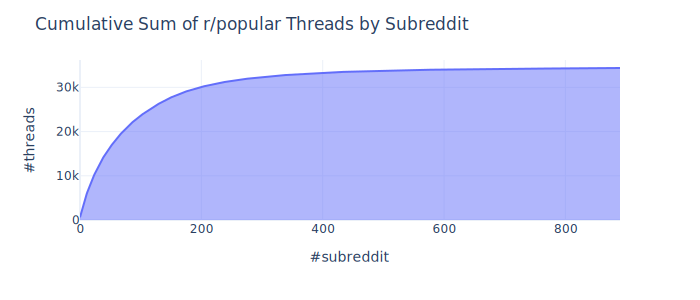

In [401]:
def display_cumulative_sum(save=False):
    
    counts = list_popular_subreddits()['num_threads'] \
        .cumsum().reset_index()
    
    fig = px.area(counts['num_threads'])
    
    fig.update_layout(
        template='plotly_white',
        showlegend=False,
        xaxis_title='#subreddit',
        yaxis_title='#threads',
        title='Cumulative Sum of r/popular Threads by Subreddit',
        height=300
    )
    
    fig.update_xaxes(showgrid=True)
    fig.update_yaxes(showgrid=True)
    
    fig.show('svg')
    
    if save:
        fig.write_image('figs/cumulative_sum.png', scale=3)

display_cumulative_sum(save=True)

# Display Pushshift collections for popular subreddits, i.e., the subreddits that reach r/popular.

In [660]:
def display_pushshift_coverage():
    
    popular_subreddits = get_popular_threads(columns=['subreddit'])['subreddit'] \
        .unique().tolist()
    
    collection_subreddits = set(pushshift_comments.list_collection_names()) \
        .intersection(set(popular_subreddits))
    
    table = {}
    
    for subreddit in tqdm(collection_subreddits):
        
        date_range = pd.DataFrame(pushshift_comments[subreddit].aggregate([
            {'$project': {'created_utc': 1}},
            {'$group': {'_id': None,
                       'min_utc': {'$min': '$created_utc'},
                       'max_utc': {'$max': '$created_utc'}}}
        ], allowDiskUse=True))
        
        table[subreddit] = {
            'N': pushshift_comments[subreddit].estimated_document_count(),
            'Start': dt.datetime.fromtimestamp(date_range['min_utc'].values[0]),
            'End': dt.datetime.fromtimestamp(date_range['max_utc'].values[0])
        }
        
    print(f'{len(collection_subreddits):,} subreddits in collection. ' \
          f'{len(popular_subreddits) - len(collection_subreddits):,} subreddits remaining.')
        
    return pd.DataFrame.from_dict(table, orient='index').sort_values(by='N', desc=False) \
        .style.format(formatter='{:,}', subset=['N'])

display_pushshift_coverage()

 27%|██▋       | 28/105 [04:22<12:00,  9.36s/it]


KeyboardInterrupt: 

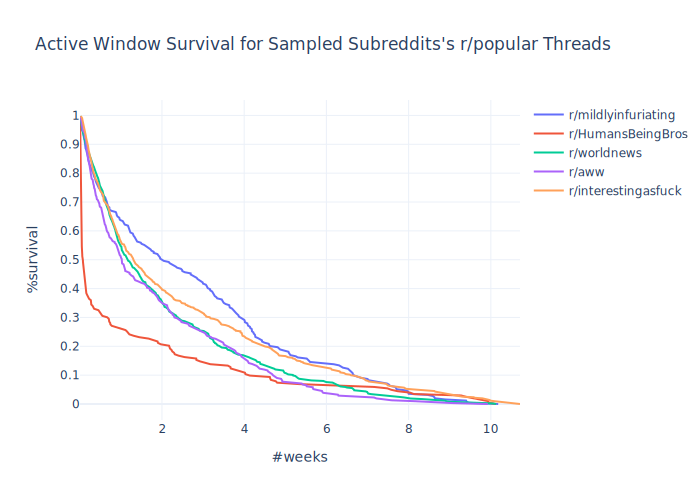

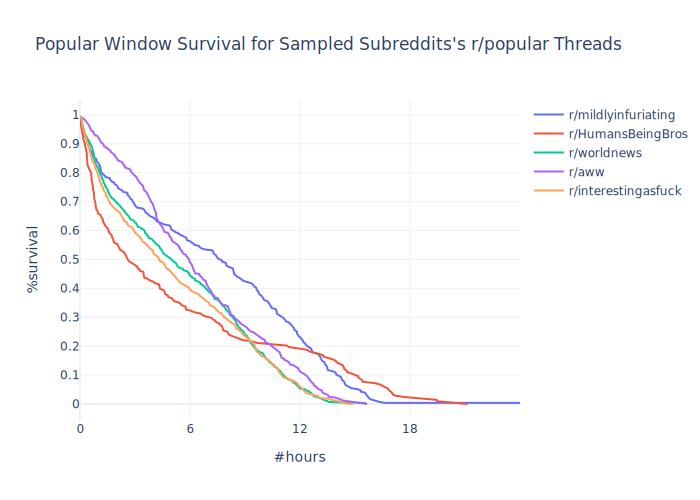

In [556]:
def display_subreddit_survival(feature, 
                               save=False,
                               subreddits=None,
                               n=5,
                               threshold=200,
                               seed=None):
    
    assert feature in ['popular_window', 'active_window']
    
    if subreddits is not None:
        sample_subreddits = subreddits
    elif seed is None:
        counts = list_popular_subreddits()
        sample_subreddits = counts[counts['num_threads'] > threshold].sample(n=n) \
            .index.to_list()
    else:
        counts = list_popular_subreddits()
        sample_subreddits = counts[counts['num_threads'] > threshold] \
            .sample(n=n, random_state=seed) \
            .index.to_list()
        
    threads = get_popular_threads(
        filter={'subreddit': {'$in': sample_subreddits},
                feature: {'$ne': None}},
        columns=[feature] + ['subreddit']
    )
    
    fig = go.Figure()
    
    if feature == 'popular_window':
        title = '#hours'
        denominator = int(dt.timedelta(hours=1).total_seconds())
        x_range = [0, 24]
        tickvals = [i for i in range(0, 24, 6)]
    else:
        title = '#weeks'
        denominator = int(dt.timedelta(days=7).total_seconds()),
        x_range = None # autorange
        tickvals = None # autorange
    
    
    for subreddit in sample_subreddits:
        
        subreddit_threads = threads[threads['subreddit'] == subreddit]
        
        time, survival_probability = kme(
            np.ones(len(subreddit_threads)).astype(bool),
            subreddit_threads[feature] / denominator
        )
        
        fig.add_trace(
            go.Scatter(
                x=time, 
                y=survival_probability, 
                name=f'r/{subreddit}'
            )
        )
    
    fig.update_xaxes(title=title,
                     range=x_range,
                     tickvals=tickvals)
    fig.update_yaxes(title='%survival', tickvals=[i / 10 for i in range(11)])
    
    feature = feature.replace('_', ' ').title()
    
    fig.update_layout(
        template='plotly_white',
        title=f'{feature} Survival for Sampled Subreddits\'s r/popular Threads' 
    )
    
    if save:
        fig.write_image('figs/subreddit_survival.png', scale=3)
        
    fig.show('svg')
    
    return

seed = 1
display_subreddit_survival('active_window', seed=seed)
display_subreddit_survival('popular_window', seed=seed)

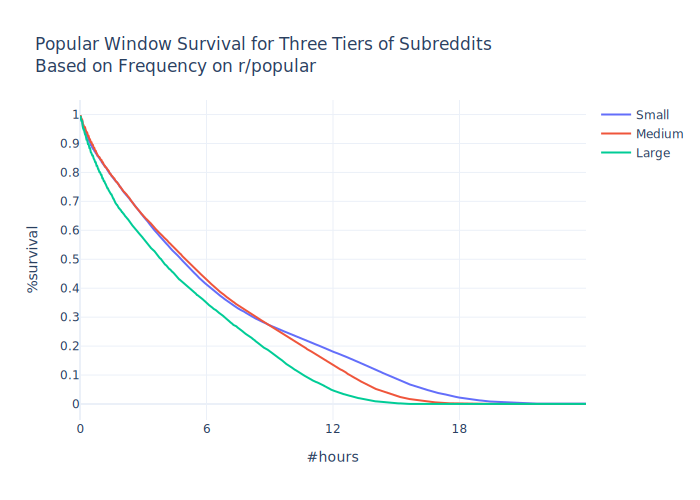

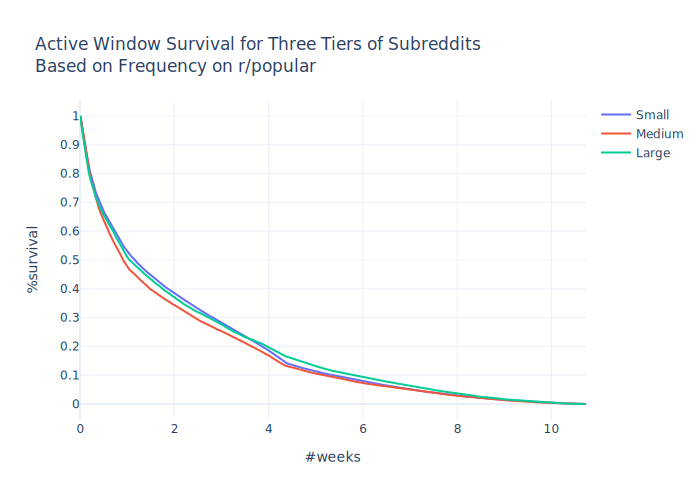

In [664]:
def display_tier_survival(feature, save=False):
    
    assert feature in ['popular_window', 'active_window']
    
    threads = get_popular_threads(
        filter={feature: {'$ne': None}},
        columns=[feature] + ['subreddit']
    )
    
    labels = pd.cut(
        list_popular_subreddits()['num_threads'], 
        bins=3, labels=['small', 'medium', 'large']
    ).to_frame().rename(columns={'num_threads': 'label'})
    
    threads = threads.join(labels, on='subreddit')
    
    if feature == 'popular_window':
        title = '#hours'
        denominator = int(dt.timedelta(hours=1).total_seconds())
        x_range = [0, 24]
        tickvals = [i for i in range(0, 24, 6)]
    else:
        title = '#weeks'
        denominator = int(dt.timedelta(days=7).total_seconds()),
        x_range = None # autorange
        tickvals = None # autorange
    
    fig = go.Figure()
    
    for label in ['small', 'medium', 'large']:
        
        label_threads = threads[threads['label'] == label]
        
        time, survival_probability = kme(
            np.ones(len(label_threads)).astype(bool),
            label_threads[feature] / denominator
        )
        
        fig.add_trace(
            go.Scatter(
                x=time,
                y=survival_probability,
                name=f'{label.title()}'
            )
        )
    
    feature_title = feature.replace('_', ' ').title()
    
    fig.update_layout(
        template='plotly_white',
        title=f'{feature_title} Survival for Three Tiers of Subreddits<br>Based on Frequency on r/popular'
    )
    
    fig.update_xaxes(title=title, range=x_range, tickvals=tickvals)
    fig.update_yaxes(title='%survival', tickvals=[i / 10 for i in range(11)])
    
    if save:
        fig.write_image(f'figs/subreddit_survival_tiers_{feature}.png', scale=3)
        
    fig.show('svg')

display_tier_survival('popular_window', save=True)
display_tier_survival('active_window', save=True)

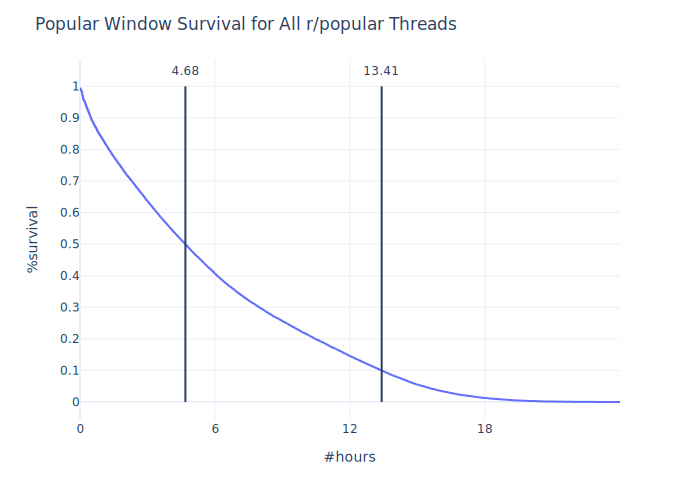

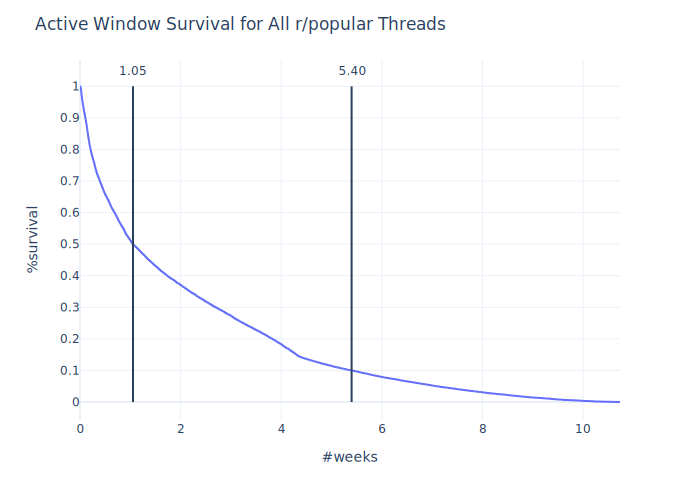

In [681]:
def display_all_survival(feature, save=False):
    
    threads = get_popular_threads(
        filter={feature: {'$ne': None}},
        columns=[feature]
    )    
    
    if feature == 'popular_window':
        title = '#hours'
        denominator = int(dt.timedelta(hours=1).total_seconds())
        x_range = [0, 24]
        tickvals = [i for i in range(0, 24, 6)]
    else:
        title = '#weeks'
        denominator = int(dt.timedelta(days=7).total_seconds()),
        x_range = None # autorange
        tickvals = None # autorange
        
    time, survival_probability = kme(
        np.ones(len(threads)).astype(bool),
        threads[feature] / denominator
    )
    
    fig = px.line(x=time, y=survival_probability)
    
    feature_title = feature.replace('_', ' ').title()
    
    fig.update_layout(
        template='plotly_white',
        showlegend=False,
        title=f'{feature_title} Survival for All r/popular Threads'
    )
    
    
    
    fig.update_xaxes(title=title, range=x_range, tickvals=tickvals)
    fig.update_yaxes(title='%survival', tickvals=[i / 10 for i in range(11)])
    
    halfway_indice = np.where(survival_probability > 0.5)[0][-1]
    
    fig.add_shape(
        type='line',
        x0=time[halfway_indice], 
        x1=time[halfway_indice],
        y0=0, y1=1
    )
    
    fig.add_annotation(
        x=time[halfway_indice], y=1.05,
        showarrow=False,
        text=f'{time[halfway_indice]:.2f}'
    )
    
    ninety_indice = np.where(survival_probability > 0.1)[0][-1]
    
    fig.add_shape(
        type='line',
        x0=time[ninety_indice], 
        x1=time[ninety_indice],
        y0=0, y1=1
    )
    
    fig.add_annotation(
        x=time[ninety_indice], y=1.05,
        showarrow=False,
        text=f'{time[ninety_indice]:.2f}'
    )
    
    if save:
        fig.write_image(f'figs/all_survival_{feature}.png', scale=3)
    
    fig.show('svg')
    
    return

display_all_survival('popular_window', save=True)
display_all_survival('active_window', save=True)

In [686]:
def newcomer_cox():
    
    threads = get_popular_threads(
        filter={'newcomer_utc': {'$ne': None}},
        columns=[
            'subreddit', 
            'active_window', 
            'popular_window',
            'num_comments',
            'is_self'
        ]
    )
    
    return threads

newcomer_cox()

,subreddit,active_window,popular_window,num_comments,is_self
id,,,,,
tkwdrr,antiwork,3641622.0,11484,1023.0,False
tkv6er,AbsoluteUnits,2154054.0,37270,1019.0,False
tktn2q,books,4023190.0,15031,1344.0,True
tktx7r,WhitePeopleTwitter,1884868.0,10874,470.0,False
tl5hed,cats,706208.0,16985,331.0,False
...,...,...,...,...,...
v6vf9h,todayilearned,17931.0,45031,130.0,False
v6wrzs,rarepuppers,14410.0,13073,31.0,False
v6ygln,gaming,11344.0,60809,551.0,False
